In [89]:
import sys
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns
import random

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

%matplotlib inline

In [90]:
shp_path = "Tracts_WUI_ByYear/trends.shp"
#shp_path = "Tracts_WUI_ByYear/tracts_wui_2010.shp"
sf = shp.Reader(shp_path)

In [91]:
def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    df = pd.DataFrame(columns=fields, data=records)
    return df

In [92]:
df = read_shapefile(sf)
print(df.shape)
df.head()

(3523, 7)


,id,county,trend,p,z,slope,intercept
0,6037500403,Los Angeles County,no trend,0.152406,-1.431084,-66.375000,4575.187500
1,6065045103,Riverside County,decreasing,0.015322,-2.424672,-94.428571,4157.928571
2,6065046404,Riverside County,increasing,0.002358,3.041052,311.000000,4748.000000
3,6065045108,Riverside County,increasing,0.004208,2.862167,212.875000,5267.062500
4,6037122122,Los Angeles County,increasing,0.001282,3.219938,84.888889,1935.000000


In [93]:
def plot_map(title, sf, value_arr, value_to_color_lambda, save = False, x_lim = None, y_lim = None, figsize = (10,10), color = 'r'):
    '''
    Plot map with lim coordinates
    '''
    
    df = read_shapefile(sf)
    plt.figure(figsize = figsize)
    fig, ax = plt.subplots(figsize = figsize)
    fig.suptitle(title, fontsize=18)
    
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
    """
    # outline
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        #x.plot(x, y, "#000000", linewidth=0.05)
    """
            
    print()
    print("# Rows:", df.shape[0])
    id_list = list(range(df.shape[0]))
    half_size = len(id_list) // 2
    quarter_size = half_size // 2
    for id in id_list:
        shape_ex = sf.shape(id)
        x_lon = np.zeros((len(shape_ex.points),1))
        y_lat = np.zeros((len(shape_ex.points),1))
        for ip in range(len(shape_ex.points)):
            x = shape_ex.points[ip][0]
            y = shape_ex.points[ip][1]
            x_lon[ip] = x
            y_lat[ip] = y
            
        color = value_to_color_lambda(df.iloc[id])
        ax.fill(x_lon,y_lat, facecolor=color, edgecolor="none")
        
        if id == quarter_size:
            print("Processing: 25%")
            
        if id == half_size:
            print("Processing: 50%")
            
        if id == half_size + quarter_size:
            print("Processing: 75%")
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)
        
    # Download map in 2 different formats
    if save:
        fig.savefig('map.svg', format='svg', dpi=1200)
        fig.savefig('map.png', format='png', dpi=1200)


# Rows: 3523
Processing: 25%
Processing: 50%
Processing: 75%


<Figure size 720x720 with 0 Axes>

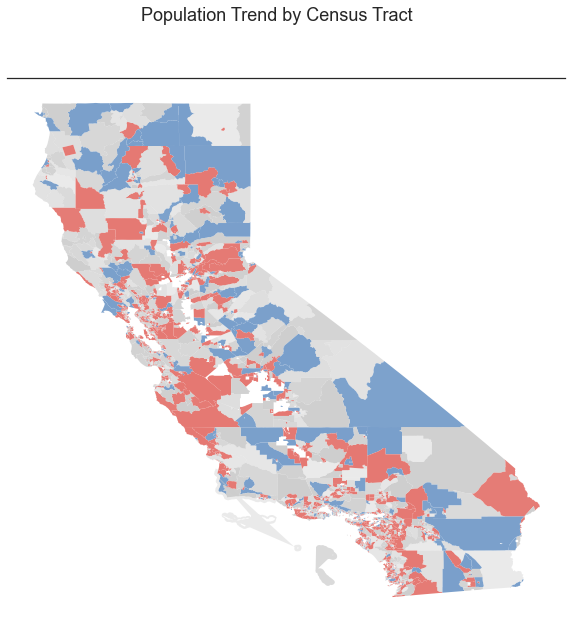

In [94]:
df = read_shapefile(sf)

sns.set(style="white", color_codes=True)

blue = "#799fcb"
red = "#e57872"
grey = "#cccccc"
white = "#ffffff"

trend_colors = {
    "increasing": red,
    "decreasing": blue,
    "no trend": grey
}

min_opacity = 0.4
def row_to_color(row):
    base_color = trend_colors[row.trend]
        
    # Clamp p-value at [0, 1] in case it isn't
    x = row.p
    if x > 1:
        x = 1
    elif x < 0:
        x = 0
    
    # Geometry go brrrr
    opacity = (1 - x) * (1 - min_opacity) + min_opacity
    
    # Create two more hex digits to represent the opacity of the color
    # The final opacity needs to be between 0x00 and 0xff, which is [0, 255] in decimal
    scaled_opacity = round(opacity * 255)
    opacity_str = hex(scaled_opacity)[2:] # [2:] strips "0x"
    opacity_str = opacity_str.zfill(2)    # pad with zeroes to make sure length = 2
    
    return base_color + opacity_str
    
plot_map("Population Trend by Census Tract", sf, df.trend, row_to_color, save = True)
sns.despine(left=True,bottom=True,top=False)